This notebook aims at reproducing results corresponding to the application of the algorithm to MAOOAM. It corresponds to Figure 3, Table 3 and Table 4 of the paper.

In [2]:
# Load the python modules.
# Load the python modules.
import os, sys
#Insert the common folder in the path (to be able to load python module)
sys.path.insert(0,os.path.join(os.path.pardir,'common'))
import numpy as np
import pandas as pd
from dapper import Chronology
from toolbox import load_data, path, rmse_norm
import matplotlib.pyplot as plt
#To control plot layouts
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("paper")

Initializing DAPPER...

but is not supported by current backend: module://ipykernel.pylab.backend_inline.
Try another backend in your settings, e.g., mpl.use('Qt5Agg').
...Done
PS: Turn off this message in your configuration: dpr_config.ini


In [3]:
#Source of the data (comment/uncomment the lines given your choice)
# The first time the notebook is executed, you must set source to 'ftp' to download the data
# If you want to rerun the notebook, you can set source to 'local'
source = 'local'
#source = 'ftp'

In [4]:
# Directory where to save the figure (if figdir = None, no figure are saved)
figdir = '.'
#figdir = None

## Load data

In [5]:
# Define the data directory containing the simulation
refdir = path('../data/MAOOAM')

# Configuration of the ftp
if source == 'ftp':
    ftpurl = 'ftp://ftp.nersc.no/reddaml/'
    ftpdir = 'MAOOAM'
else:
    ftpurl, ftpdir = None, None

# True simulation file:
ftruth = 'simul-truth-T200000.0.npy'

# Truncated simulation file
ftrunc = 'simul-trunc-T200000.0.npy'

# Perfect obs hybrid model
fperfect = 'simul-perfect-T200000.0.npy'

# DA-derived hybrid model
fhybrid = 'simul-hybrid-T200000.0.npy'

# Define chrono
f0 = 1.032e-4  # Coriolis parameter at 45 degrees latitude
T = 2e5 #Length of the experiment (in MTU)
dtObs = 10 #Observation time
dt = 1.e-2 #integration time step
chrono = Chronology(dt, dtObs=dtObs, T=T)
tt = chrono.tt[::chrono.dkObs]/f0/(3600*24) #in days

#Check if figdir exist and set the figdir bool accordingly
savefig = bool(figdir)

In [6]:
# Load the data (it can take few minutes)
xx_truth = load_data(refdir,ftruth,ftpurl=ftpurl,ftpdir=ftpdir)
xx_trunc = load_data(refdir,ftrunc,ftpurl=ftpurl,ftpdir=ftpdir)
xx_perfect = load_data(refdir,fperfect,ftpurl=ftpurl,ftpdir=ftpdir)
xx_hybrid = load_data(refdir,fhybrid,ftpurl=ftpurl,ftpdir=ftpdir)


In [7]:
#Print shapes
print('Size of the time axis:',tt.shape)
print('Size of the truth simulation (time step, members, space):',xx_truth.shape)
print('Size of the trunc simulation (time step, members, space):',xx_trunc.shape)

#Basic test
assert xx_truth.shape[0] == tt.shape[0]
assert xx_trunc.shape[0] == tt.shape[0]
assert xx_hybrid.shape[0] == tt.shape[0]
assert xx_perfect.shape[0] == tt.shape[0]
assert xx_trunc.shape[1] == xx_truth.shape[1]
assert xx_perfect.shape[1] == xx_truth.shape[1]
assert xx_hybrid.shape[1] == xx_truth.shape[1]

Size of the time axis: (20001,)
Size of the truth simulation (time step, members, space): (20001, 20, 56)
Size of the trunc simulation (time step, members, space): (20001, 20, 36)


In [8]:
#Project xx_truth on the truncated state
ivar36 = [
    0,  1,  2,  3,  4,  5, 12, 13, 14, 15, #psi
    20, 21, 22, 23, 24, 25, 32, 33, 34, 35, #theta
    40, 41, 42, 43, 44, 45, 46, 47, #A
    48, 49, 50, 51, 52, 53, 54, 55 #T
]
xx_truth_36 = xx_truth[...,ivar36]
print('Size of the truth simulation subsampled (time step, members, space):',xx_truth_36.shape)
assert xx_truth_36.shape[2] == 36

Size of the truth simulation subsampled (time step, members, space): (20001, 20, 36)


In [9]:
#Key variable to consider tuple(space dim, short name, pretty print)
lvar2plot = [
    (21,'psio2',r'$\Psi_{o,2}$'),
    (29,'thetao2',r'$\theta_{o,2}$'),
    (0,'psia1',r'$\Psi_{a,1}$')]

## Plot attractor
Plot the figure 3 of the article

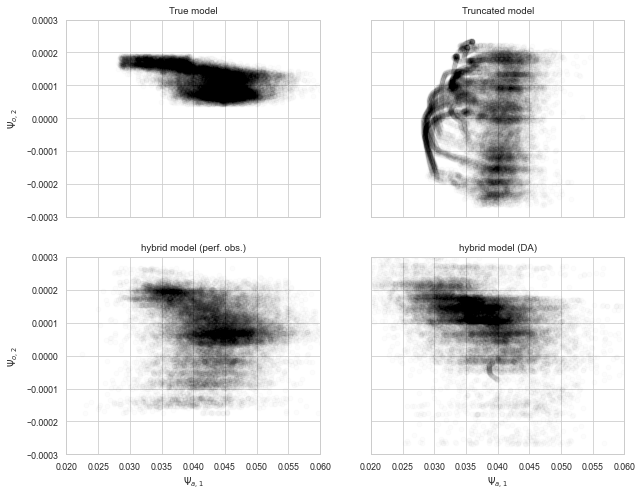

In [10]:
burn=1000
subsample = 20
varlim = [(-3e-4,3e-4),(2e-2, 18e-2),(0.02,0.06)]
fig, ax = plt.subplots(ncols=2, nrows=2, sharex='all', sharey='all',figsize=(10,8))
i0, var0, strvar0 = lvar2plot[0]
i1, var1, strvar1 = lvar2plot[1]
i2, var2, strvar2 = lvar2plot[2]

alpha = 10e-3

sns.regplot(xx_truth_36[burn::subsample,:,i2].ravel(),xx_truth_36[burn::subsample,:,i0].ravel(),
                    scatter_kws={'alpha':alpha}, fit_reg=False, ax=ax[0,0], color='black')
ax[0,0].set_xlim(varlim[2])
ax[0,0].set_ylim(varlim[0]);
ax[0,0].set_ylabel(strvar0)
ax[0,0].set_title('True model')
sns.regplot(xx_trunc[burn::subsample,:,i2].ravel(),xx_trunc[burn::subsample,:,i0].ravel(),
                    scatter_kws={'alpha':alpha}, fit_reg=False, ax=ax[0,1], color='black')
ax[0,1].set_xlim(varlim[2])
ax[0,1].set_ylim(varlim[0]);
ax[0,1].set_title('Truncated model')

sns.regplot(xx_perfect[burn::subsample,:,i2].ravel(),xx_perfect[burn::subsample,:,i0].ravel(),
                    scatter_kws={'alpha':alpha}, fit_reg=False, ax=ax[1,0], color='black')
ax[1,0].set_xlim(varlim[2])
ax[1,0].set_ylim(varlim[0]);
ax[1,0].set_ylabel(strvar0)
ax[1,0].set_xlabel(strvar2)
ax[1,0].set_title('hybrid model (perf. obs.)')


sns.regplot(xx_hybrid[burn::subsample,:,i2].ravel(),xx_hybrid[burn::subsample,:,i0].ravel(),
                    scatter_kws={'alpha':alpha}, fit_reg=False, ax=ax[1,1], color='black')
ax[1,1].set_xlim(varlim[2])
ax[1,1].set_ylim(varlim[0]);
ax[1,1].set_xlabel(strvar2);
ax[1,1].set_title('hybrid model (DA)');

#Save (if needed)
if figdir:
    fig.savefig(os.path.join(figdir,'philtra-fig3.png'),
            dpi=200, bbox_inches='tight', pad_inches=0)

## Forecast skill
compute the table 3 of the article

In [11]:
#Lead time (in days)
dltime = {'psio2':700, 'thetao2': 700, 'psia1': 1}
stats = np.zeros((3,len(dltime)))


for i, (ivar, var, strvar) in enumerate(lvar2plot):
    ltime = dltime[var]
    itime = int(np.argmin(np.abs(tt-ltime)))
    stats[0,i] = rmse_norm(xx_trunc[itime:itime+1,:,ivar],xx_truth_36[itime:itime+1,:,ivar], axis=1)
    stats[1,i] = rmse_norm(xx_perfect[itime:itime+1,:,ivar],xx_truth_36[itime:itime+1,:,ivar], axis=1)
    stats[2,i] = rmse_norm(xx_hybrid[itime:itime+1,:,ivar],xx_truth_36[itime:itime+1,:,ivar], axis=1)
df_forecast = pd.DataFrame(stats, 
                           columns=[var for _,var,_ in lvar2plot],
                           index=['Truncated','perf. obs.', 'DA'])
#Save (if needed)
if figdir:
    df_forecast.to_csv(os.path.join(figdir,'tab-3.csv'))
    
df_forecast

,psio2,thetao2,psia1
Truncated,0.231778,0.206322,0.361256
perf. obs.,0.071492,0.066656,0.233658
DA,0.100080,0.061797,0.278131


## Quantiles
Compute the table 4 of the article

In [12]:
pd.options.display.float_format = '{:.2e}'.format
burn = 1000
columns = [var+'_'+stat for _, var, _ in lvar2plot for stat in ['Q1','med','Q3'] ]
stats = np.zeros((4,len(columns)))
for i, (ivar, var, strvar) in enumerate(lvar2plot):
    stats[0,(i*3):(i*3)+3] = np.percentile(xx_truth_36[burn:,:,ivar].ravel(),[25, 50, 75]) 
    stats[1,(i*3):(i*3)+3] = np.percentile(xx_trunc[burn:,:,ivar].ravel(),[25, 50, 75]) 
    stats[2,(i*3):(i*3)+3] = np.percentile(xx_perfect[burn:,:,ivar].ravel(),[25, 50, 75]) 
    stats[3,(i*3):(i*3)+3] = np.percentile(xx_hybrid[burn:,:,ivar].ravel(),[25, 50, 75]) 

df = pd.DataFrame(stats,columns=columns,index=['Truth','Truncated','perf. obs.', 'DA'])
df.loc['Diff_trunc'] = (df.loc['Truncated'] - df.loc['Truth'])/df.loc['Truth']
df.loc['Diff_perfobs'] = (df.loc['perf. obs.'] - df.loc['Truth'])/df.loc['Truth']
df.loc['Diff_da'] = (df.loc['DA'] - df.loc['Truth'])/df.loc['Truth']

#Save (if needed)
if figdir:
    df_forecast.to_csv(os.path.join(figdir,'tab-4.csv'))

#Print the data frame (the raws 2,3 and 4 are not reproduced in the article)
df

,psio2_Q1,psio2_med,psio2_Q3,thetao2_Q1,thetao2_med,thetao2_Q3,psia1_Q1,psia1_med,psia1_Q3
Truth,7.80e-05,1.12e-04,1.50e-04,8.23e-02,1.22e-01,1.41e-01,3.88e-02,4.33e-02,4.63e-02
Truncated,-1.01e-04,2.23e-05,1.10e-04,6.45e-02,1.10e-01,1.32e-01,3.40e-02,3.86e-02,4.14e-02
perf. obs.,3.49e-05,8.27e-05,1.51e-04,8.79e-02,1.20e-01,1.35e-01,3.85e-02,4.25e-02,4.63e-02
DA,6.68e-05,1.23e-04,1.62e-04,8.90e-02,1.16e-01,1.41e-01,3.30e-02,3.72e-02,4.11e-02
Diff_trunc,-2.29e+00,-8.01e-01,-2.63e-01,-2.16e-01,-9.72e-02,-6.20e-02,-1.22e-01,-1.07e-01,-1.05e-01
Diff_perfobs,-5.53e-01,-2.64e-01,6.34e-03,6.86e-02,-1.87e-02,-3.88e-02,-5.58e-03,-1.82e-02,2.27e-04
Diff_da,-1.44e-01,9.26e-02,8.32e-02,8.20e-02,-4.80e-02,-1.69e-03,-1.49e-01,-1.40e-01,-1.13e-01
